# Setup and Imports

In [12]:
!pip install LPIPS

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset  # Make sure to import Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from lpips import LPIPS

# Initialize LPIPS metric
lpips_metric = LPIPS(net='vgg').cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


# Data Preprocessing

In [14]:
# Define transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for faster training
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the CIFAR-10 training set
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# TODO: select 3 categories as training dataset
selected_classes = ["cat", "dog", "frog"]
selected_class_indices = [3, 5, 6]

# Collect 100 images for each class
subset_indices = []
class_counts = {index: 0 for index in selected_class_indices}

for idx, (image, label) in enumerate(cifar10_train):
    if label in selected_class_indices and class_counts[label] < 100:
        subset_indices.append(idx)
        class_counts[label] += 1
    if all(count >= 100 for count in class_counts.values()):
        break

# Create a subset for training
cifar10_subset = Subset(cifar10_train, subset_indices)
train_loader = DataLoader(cifar10_subset, batch_size=4, shuffle=True)

Files already downloaded and verified


In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(DecoderBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5) if dropout else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)
    
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

# Define the Generator and Discriminator

In [16]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # TODO: define a UNet-like generator
        self.encoder1 = EncoderBlock(3, 8)      # 3 * 64 * 64 -> 8 * 32 * 32
        self.encoder2 = EncoderBlock(8, 16)     # 8 * 32 * 32 -> 16 * 16 * 16
        self.encoder3 = EncoderBlock(16, 32)    # 16 * 16 * 16 -> 32 * 8 * 8
        self.encoder4 = EncoderBlock(32, 64)    # 32 * 8 * 8 -> 64 * 4 * 4
        self.encoder5 = EncoderBlock(64, 64)    # 64 * 4 * 4 -> 64 * 2 * 2
        self.encoder6 = nn.Sequential(          # 64 * 2 * 2 -> 64 * 1 * 1
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
        )
        
        self.decoder6 = DecoderBlock(64, 64, dropout=True)      # 64 * 1 * 1 -> 64 * 2 * 2
        self.decoder5 = DecoderBlock(2*64, 64, dropout=True)    # (2 * 64) * 2 * 2 -> 64 * 4 * 4
        self.decoder4 = DecoderBlock(2*64, 32)                  # (2 * 64) * 4 * 4 -> 32 * 8 * 8
        self.decoder3 = DecoderBlock(2*32, 16)                  # (2 * 32) * 8 * 8 -> 16 * 16 * 16
        self.decoder2 = DecoderBlock(2*16, 8)                   # (2 * 16) * 16 * 16 -> 8 * 32 * 32
        self.decoder1 = nn.Sequential(                          # (2 * 8) * 32 * 32 -> 3 * 64 * 64
            nn.ConvTranspose2d(2*8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        
        d6 = self.decoder6(e6)
        d5 = self.decoder5(torch.cat([d6, e5], dim=1))
        d4 = self.decoder4(torch.cat([d5, e4], dim=1))
        d3 = self.decoder3(torch.cat([d4, e3], dim=1))
        d2 = self.decoder2(torch.cat([d3, e2], dim=1))
        d1 = self.decoder1(torch.cat([d2, e1], dim=1))
        return d1

class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        # TODO: define a simple PatchGAN discriminator
        self.model = nn.Sequential(
            nn.Conv2d(6, 32, 4, 2, 1),      # 6 * 64 * 64 -> 16 * 32 * 32
            nn.LeakyReLU(0.2, inplace=True),
            BasicBlock(32, 32),             # 16 * 32 * 32 -> 32 * 16 * 16
            BasicBlock(32, 64),             # 32 * 16 * 16 -> 64 * 8 * 8
            BasicBlock(64, 128),            # 64 * 8 * 8 -> 128 * 4 * 4
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1), # 128 * 4 * 4 -> 1 * 2 * 2
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)

# Model Training

In [18]:
generator = UNetGenerator().cuda()
discriminator = PatchGANDiscriminator().cuda()

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Add learning rate schedulers
scheduler_G = optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=200)
scheduler_D = optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=200)

# Track losses for plotting
g_losses, d_losses = [], []

def train():
    epochs = 200
    generator.train()
    for epoch in range(epochs):  # Train for 20 epochs
        g_loss_epoch, d_loss_epoch = 0, 0
        for i, (input_img, _) in enumerate(train_loader):
            target_img = input_img  # Using the same images as targets for simplicity
            input_img, target_img = input_img.cuda(), target_img.cuda()
            
            # Train Discriminator
            optimizer_D.zero_grad()
            fake_img = generator(input_img)
            real_data = torch.cat((input_img, target_img), 1)
            fake_data = torch.cat((input_img, fake_img.detach()), 1)
            fake_data = torch.cat((input_img, fake_img.detach()), 1)
            real_loss = criterion_GAN(discriminator(real_data), torch.ones_like(discriminator(real_data)).cuda())
            fake_loss = criterion_GAN(discriminator(fake_data), torch.zeros_like(discriminator(fake_data)).cuda())
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss_GAN = criterion_GAN(discriminator(fake_data), torch.ones_like(discriminator(fake_data)).cuda())
            g_loss_L1 = criterion_L1(fake_img, target_img)
            g_loss = g_loss_GAN + 100 * g_loss_L1
            g_loss.backward()
            optimizer_G.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()

        # Record average losses per epoch
        g_losses.append(g_loss_epoch / len(train_loader))
        d_losses.append(d_loss_epoch / len(train_loader))
        
        scheduler_G.step()
        scheduler_D.step()

        print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_losses[-1]:.6f}, G Loss: {g_losses[-1]:.4f}, lr: {scheduler_D.get_last_lr()[0]:.8f}")
        

train()


Epoch [1/200], D Loss: 0.371818, G Loss: 42.5391, lr: 0.00019999
Epoch [2/200], D Loss: 0.053517, G Loss: 28.3114, lr: 0.00019995
Epoch [3/200], D Loss: 0.045972, G Loss: 23.1796, lr: 0.00019989
Epoch [4/200], D Loss: 0.033786, G Loss: 22.2017, lr: 0.00019980
Epoch [5/200], D Loss: 0.007028, G Loss: 21.3912, lr: 0.00019969
Epoch [6/200], D Loss: 0.005298, G Loss: 21.6346, lr: 0.00019956
Epoch [7/200], D Loss: 0.003852, G Loss: 21.6350, lr: 0.00019940
Epoch [8/200], D Loss: 0.002919, G Loss: 21.6440, lr: 0.00019921
Epoch [9/200], D Loss: 0.002511, G Loss: 20.7136, lr: 0.00019900
Epoch [10/200], D Loss: 0.076668, G Loss: 21.6852, lr: 0.00019877
Epoch [11/200], D Loss: 0.156926, G Loss: 18.7533, lr: 0.00019851
Epoch [12/200], D Loss: 0.005225, G Loss: 19.9577, lr: 0.00019823
Epoch [13/200], D Loss: 0.003814, G Loss: 20.1753, lr: 0.00019792
Epoch [14/200], D Loss: 0.003510, G Loss: 19.5781, lr: 0.00019759
Epoch [15/200], D Loss: 0.001979, G Loss: 19.7478, lr: 0.00019724
Epoch [16/200], D L

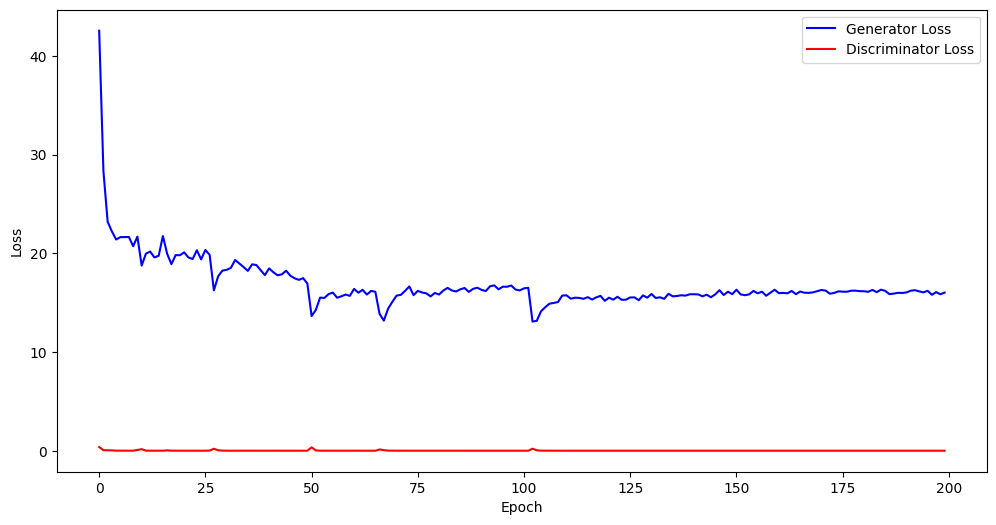

In [19]:
# TODO: plot Generator and Discriminator loss, Epoch=1000
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label='Generator Loss', color='b')
plt.plot(d_losses, label='Discriminator Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Result

## Quantitative analysis

In [28]:
# TODO: define evaluate function to print evaluation result of PSNR/SSIM/LPIPS
def evaluate():
    generator.eval()
    psnr_list, ssim_list, lpips_list = [], [], []
    for i, (input_img, _) in enumerate(train_loader):
        target_img = input_img
        target_img, input_img = target_img.cuda(), input_img.cuda()
        fake_img = generator(input_img)
        for j in range(fake_img.shape[0]):
            np_target_img = (target_img[j].detach().cpu().numpy().transpose(1,2,0) + 1) / 2
            np_target_img = np.uint8(np_target_img * 255)
            np_fake_img = (fake_img[j].detach().cpu().numpy().transpose(1,2,0) + 1) / 2
            np_fake_img = np.uint8(np_fake_img * 255)
            psnr_list.append(psnr(np_target_img, np_fake_img))
            ssim_list.append(ssim(np_target_img, np_fake_img, channel_axis=-1))
            lpips_list.append(lpips_metric(fake_img[j], target_img[j]).item())
    print(f"Average PSNR: {np.mean(psnr_list):.4f}")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")
    print(f"Average LPIPS: {np.mean(lpips_list):.4f}")

In [29]:
evaluate()

Average PSNR: 32.4183
Average SSIM: 0.9504
Average LPIPS: 0.1148


## Qualitative analysis

In [22]:
# TODO: define visualization function for Qualitative analysis.
# Select 4 images of each inference from 3 categories
def inference_and_visualize():
    generator.eval()
    result = {}
    for idx in selected_class_indices:
        result[idx] = []
    for i, (input_img, label) in enumerate(train_loader):
        input_img = input_img.cuda()
        fake_img = generator(input_img)
        for j in range(4):
            result[label[j].item()].append((((fake_img[j] + 1) / 2).detach().cpu().numpy().transpose(1, 2, 0)))
    plt.subplots(3, 4, figsize=(12, 9))
    for i, idx in enumerate(selected_class_indices):
        for j in range(4):
            ax = plt.subplot(3, 4, 4 * i + j + 1)
            ax.set_title(f"{selected_classes[i]}")  # 模擬分類
            ax.axis('off')
            plt.imshow(result[idx][j])
    plt.show()

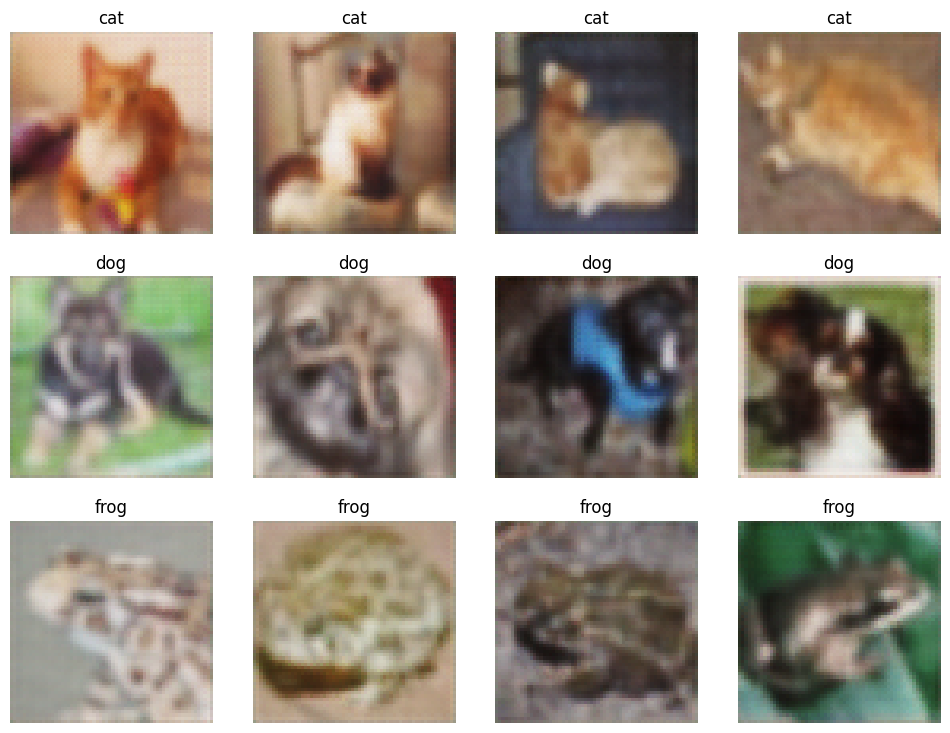

In [23]:
# Epoch=1000
inference_and_visualize()

### HW2.4: Discuss the pros and cons of Pix2Pix compared with older methods. 

* pros
    * Pix2Pix can be easily applied to various tasks such as image colorization, object segmentation, and style transfer by simply adjusting the input image and target image features.
    * The entire model operates in an end-to-end manner, eliminating the need for manual feature extraction or image enhancement techniques.
    *  Since Pix2Pix is based on a GAN architecture, it has a potential in generating diverse outputs compared to traditional regression or classification methods.

* cons
    * Pix2Pix requires paired training data, which may be difficult to obtain in certain domains.
    * As a GAN-based model, it can be challenging to train and is sensitive to hyperparameters, potentially leading to unstable performance.
    * Compared to more lightweight methods, Pix2Pix demands more computational resources for both training and inference.